# Fraud Detection -- Isolated Forest & XGBoosting
Steps

1. Descriptive Data Analysis
- What's the data distributions like?
- Check correlation matrix.
- Which types of transactions are fraudulent?

2. Data Cleaning
- Detech null values.
- Prepare datasets.

3. Data Visualization
- Check dispersion over time and transaction amount.

4. Machine Learning application
- Supervised - XGBoosting
- Unsupervised - Isolation Forest
- Unsupervised - LOF

5. evaluation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
sns.__version__

'0.11.0'

In [2]:
df = pd.read_csv('/home/jovyan/work/DetectFraud/archive (1).zip')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

## 1. Descriptive Analysis

Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# no Null values found. But this doesnt rule out cases when 0 -> null
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


CPU times: user 2min, sys: 15.5 s, total: 2min 16s
Wall time: 2min 1s


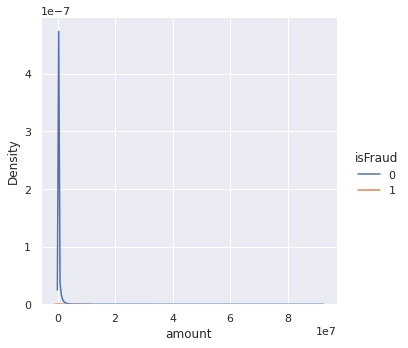

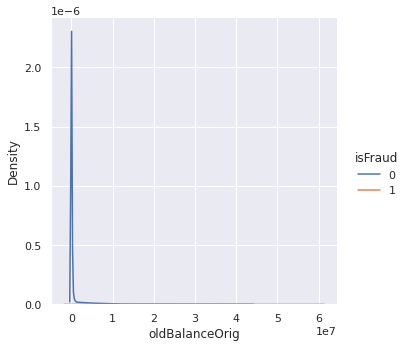

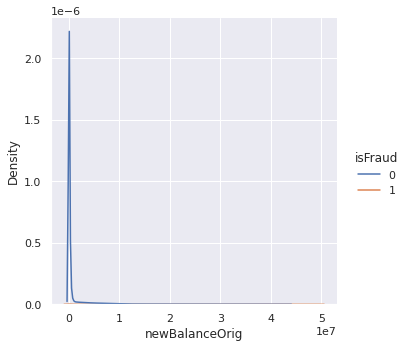

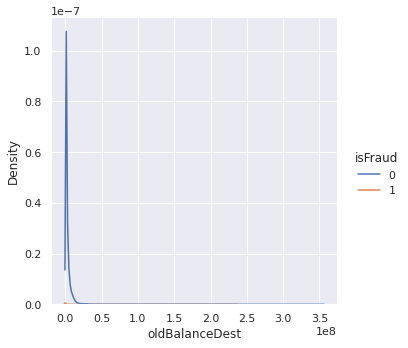

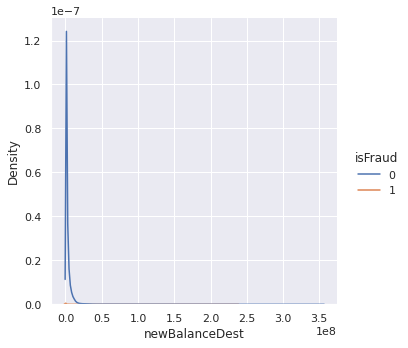

In [7]:
%%time

# plot kde for continous variable in the final list of origination variables.

sns.set(color_codes=True)

origination_cols_final_wdis = ['amount','oldBalanceOrig','newBalanceOrig',
                               'oldBalanceDest','newBalanceDest']


for col_id in origination_cols_final_wdis:
    sns.displot(df, x = col_id, hue = "isFraud", kind = 'kde')

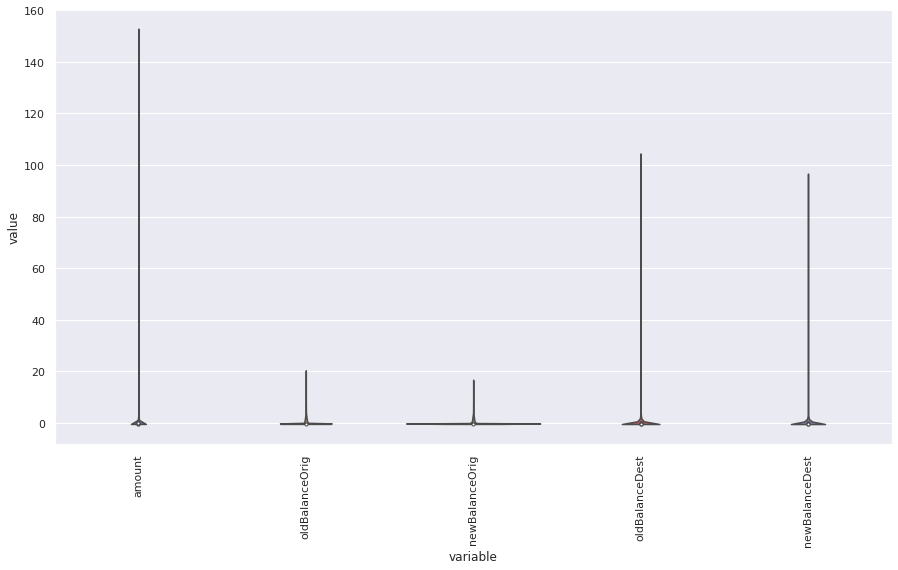

In [8]:
from scipy.stats import zscore
df_amount_normed = df[origination_cols_final_wdis].apply(zscore)
fig, ax = plt.subplots(figsize=(15,8))
a = sns.violinplot(x='variable', y='value', data=pd.melt(df_amount_normed), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

In [9]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

### 1.1. Which types of transactions are fraudulent?

In [10]:
# WE can see that Fraud related types are CASH-OUT and Transfer
df.groupby('type')['isFraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

- 'TRANSFER': where money is sent to a customer / fraudster 
- 'CASH_OUT': where money is sent to a merchant who pays the customer / fraudster in cash. 
- the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs 
- namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out.

### 1.2. Observe correlations b/t predictors.

In [11]:
df['isFlaggedFraud'].sum()

16

<AxesSubplot:>

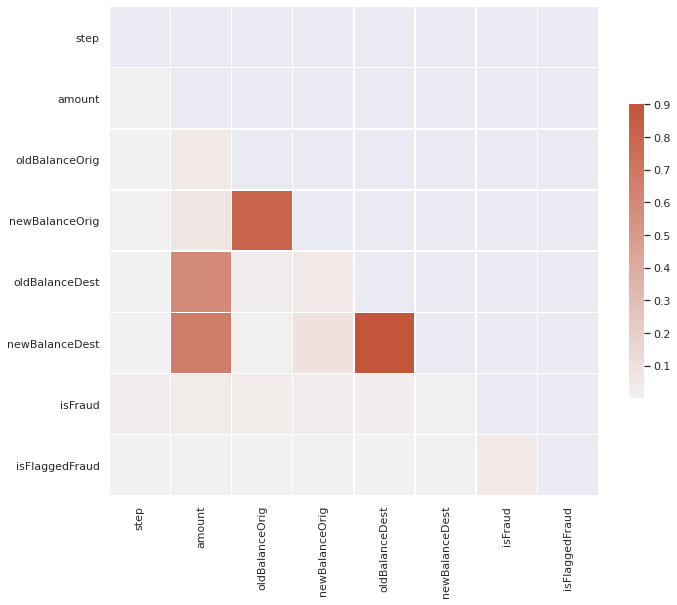

In [12]:
# original/destination accounts before/after are closely related. 
# fraud flagged are not correlated to actual frauds.
corr = df.corr(method='spearman')
corr = np.abs(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .6})

# 2. Data Cleaning

In [3]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
X = X.drop(['nameOrig', 'nameDest'], axis = 1)

Y = X['isFraud']
del X['isFraud']

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [14]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFlaggedFraud
2,1,0,181.00,181.0,0.0,0.0,0.00,0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [15]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

# 3. Data Viz

In [16]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


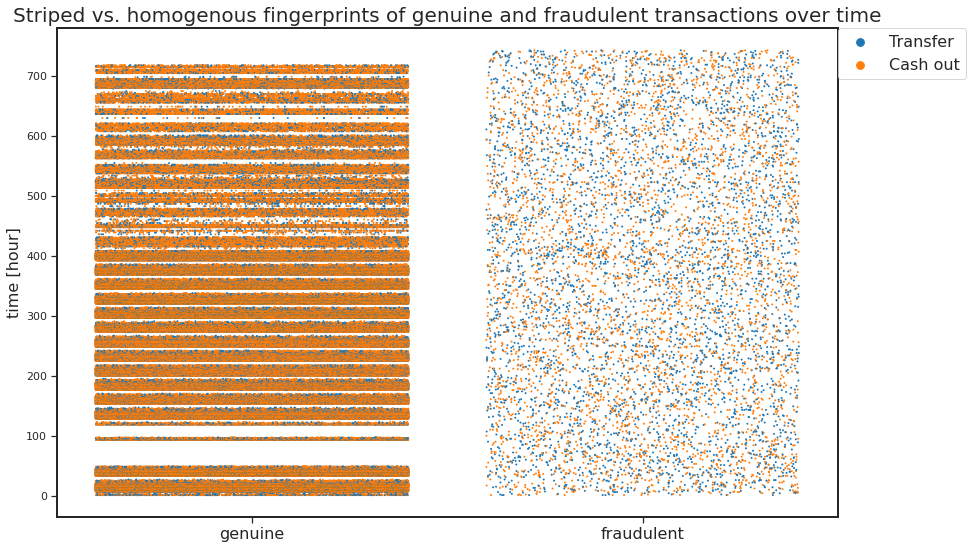

In [17]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


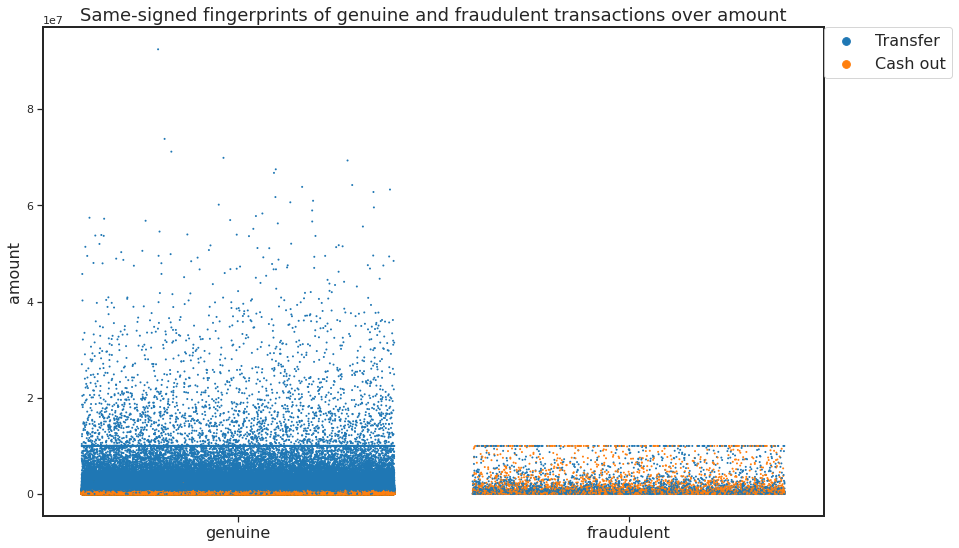

In [18]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

# 4. Machine Learning applications

## 4.1 Supervised Learning -- XGBoosting for fraud detection

In [7]:
randomState = 2021
np.random.seed(randomState)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [20]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3,
                    scale_pos_weight = weights,
                    n_jobs = 4)


In [21]:
# Define the parameters for grid search
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train_X = trainX.sample(frac = 0.05,               # The fraction to extract
                                       random_state = 251121229,    # The seed.
                                       )
val_train_Y = trainY.sample(frac = 0.05,               # The fraction to extract
                                       random_state = 251121229,    # The seed.
                                       )

In [24]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(clf,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'recall', # How to rank outputs.
                       n_jobs = 12,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [25]:
# Long computation in this cell (~8.9 minutes)
# Train grid search.
GridXGB.fit(val_train_X, val_train_Y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed:  6.9min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=336.3199805186899,
                                     subsample=None, tree_metho

In [26]:
import pickle
pkl_filename = 'dt_xgb_cv.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GridXGB, file)
 

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [27]:
clf = XGBClassifier(max_depth = GridXGB.best_params_.get('max_depth'),
                    scale_pos_weight = weights,
                    learning_rate=GridXGB.best_params_.get('learning_rate'),
                    n_estimators=GridXGB.best_params_.get('n_estimators'),
                    n_jobs = 12)

In [28]:
%%time
# Long computation in this cell (~22.4s)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.8730024668630854
CPU times: user 2min 36s, sys: 187 ms, total: 2min 36s
Wall time: 22.4 s


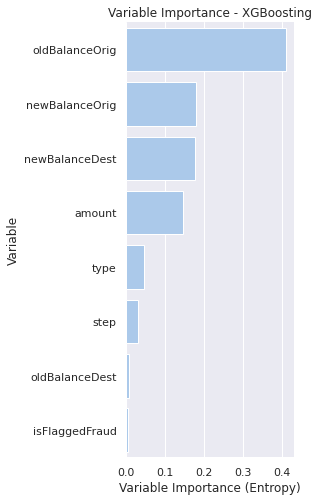

In [29]:
# Plot variable importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[trainX.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

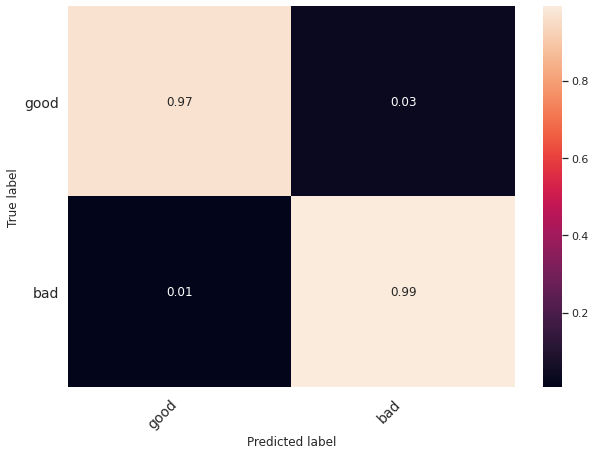

In [31]:
# Calculate probability
XGBClassTest = clf.predict(testX)
xg_probs_test = clf.predict_proba(testX)
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = testY, 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

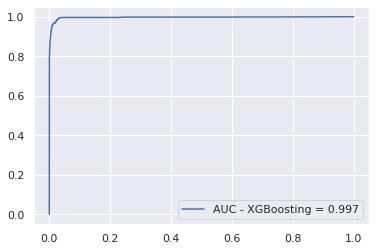

In [32]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(testY, 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = testY, 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

In [53]:
from sklearn.metrics import accuracy_score, recall_score
print(accuracy_score(testY,XGBClassTest),
recall_score(testY,XGBClassTest))

0.9684108128399768 0.9920876445526476


In [34]:
confusion_matrix(y_true = testY, 
                    y_pred = XGBClassTest)

array([[534949,  17490],
       [    13,   1630]])

## 4.2 Unsupervised Learning - Isolation Forest to identify anomalies

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
trainY.sum()/trainY.count()

0.0029643640130720783

In [37]:
IF=IsolationForest(n_estimators=100, 
                    max_samples='auto', 
                    contamination=0.003,
                    max_features=1.0, 
                    bootstrap=True, 
                    n_jobs=-1, 
                    random_state=randomState, 
                    verbose=0)

In [42]:
from sklearn.metrics import recall_score
def n_estimators_tune(): 
    n_estimators = [1, 2, 4, 8, 16, 20, 25, 32, 64, 100]
    train_results = []
    test_results = []
    for estimator in n_estimators:
        IF = IsolationForest(n_estimators=estimator, n_jobs=-1)
        IF.fit(trainX, trainY)
        train_pred = IF.predict(trainX)
        
        #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
        train_pred[train_pred == 1] = 0
        train_pred[train_pred == -1] = 1
        train_results.append(recall_score(trainY,train_pred))
        
        y_pred = IF.predict(testX)
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        test_results.append(recall_score(testY,y_pred))
        
       
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label='Train Recall')
    line2, = plt.plot(n_estimators, test_results, 'r', label='Test Recall')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Recall score')
    plt.xlabel('n_estimators')
    plt.show()

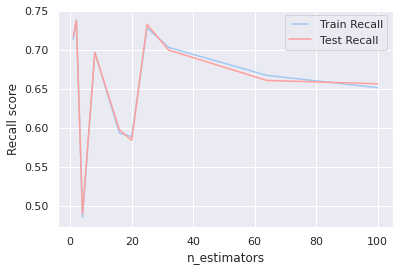

In [43]:
n_estimators_tune()

In [44]:
IF=IsolationForest(n_estimators=25, 
                    max_samples='auto', 
                    contamination=0.003, 
                    max_features=1.0,
                    bootstrap=True, 
                    n_jobs=-1, 
                    random_state=randomState, 
                    verbose=0)

In [45]:
IF.fit(trainX)

IsolationForest(bootstrap=True, contamination=0.003, n_estimators=25, n_jobs=-1,
                random_state=2021)

In [47]:
import pickle
pkl_filename = 'df_if.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(IF, file)
 

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [15]:
from sklearn.metrics import classification_report

In [48]:
y_pred = IF.predict(testX)
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [52]:
print(accuracy_score(testY,y_pred),
recall_score(testY,y_pred))

0.9942210719712967 0.03712720632988436


In [50]:
confusion_matrix(y_true = testY, 
                    y_pred = y_pred)

array([[550819,   1620],
       [  1582,     61]])

## 4.3 Local Outlier Factor
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen: 
1. greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster
2. smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [20]:
from sklearn.metrics import SCORERS, confusion_matrix
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [4]:
from sklearn.neighbors import LocalOutlierFactor

In [63]:
LOF = LocalOutlierFactor(n_neighbors=20, 
                   algorithm='auto',                 
                   leaf_size=30,
                   metric='minkowski',
                   p=2, 
                   metric_params=None, 
                   contamination=0.003,
                   n_jobs=-1,
                   novelty=True)


By default, LocalOutlierFactor is only meant to be used for outlier detection (novelty=False). Set novelty to True if you want to use LocalOutlierFactor for novelty detection. In this case be aware that that you should only use predict, decision_function and score_samples on new unseen data and not on the training set.

In [96]:
from sklearn.metrics import recall_score
def n_neighbors_tune(): 
    n_neighbors = [1,4, 8, 16, 20, 25, 35, 64, 100]
    train_results = []
    test_results = []
    for neighbor in n_neighbors:
        LOF = LocalOutlierFactor(n_neighbors=neighbor, n_jobs=-1, novelty=True)
        LOF.fit(trainX)
        train_pred = LOF.predict(testX)
        
        #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
        train_pred[train_pred == 1] = 0
        train_pred[train_pred == -1] = 1
        train_results.append(recall_score(testY,train_pred))
        

    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_neighbors, train_results, 'b', label='Train Recall')
    line2, = plt.plot(n_neighbors, test_results, 'r', label='Test Recall')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Recall score')
    plt.xlabel('n_neighbors')
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

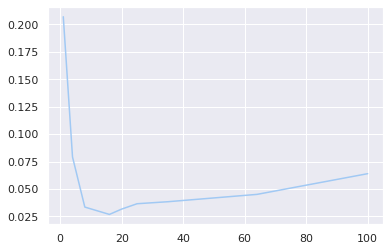

In [97]:
n_neighbors_tune()

In [8]:
LOF = LocalOutlierFactor(n_neighbors=1, 
                   algorithm='auto',                 
                   leaf_size=30,
                   metric='minkowski',
                   p=2, 
                   metric_params=None, 
                   contamination=0.003,
                   n_jobs=-1,
                   novelty=True)

In [9]:
LOF.fit(trainX)

LocalOutlierFactor(contamination=0.003, n_jobs=-1, n_neighbors=1, novelty=True)

In [22]:
y_pred_lof = LOF.predict(testX)
scores_prediction = LOF.negative_outlier_factor_

In [11]:
scores_prediction

array([-2.09819704, -1.62341205, -1.27167712, ..., -1.12510053,
       -1.9820542 , -1.        ])

In [23]:
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

In [13]:
LOF.decision_function(testX)

array([7.30561678, 8.06280449, 9.20708998, ..., 8.68968253, 8.17616455,
       9.20708998])

In [27]:
print(accuracy_score(testY,y_pred_lof),
recall_score(testY,y_pred_lof))

0.99420663367516 0.019476567255021303


In [26]:
confusion_matrix(y_true = testY, 
                    y_pred = y_pred_lof)

array([[550840,   1599],
       [  1611,     32]])

# 5. Evaluation
- All models do well in identifying normal case, which is not the priority in Fraud Detection.

- under XGBoosting, the precision for Fraud (1) is 0.28 and recall is 0.99. Meaning that XGBoosting can get most of the fraud but there are also many false kills. This is the ideal case we expect but more often, supervised learning in Fraud Detection is a luxury.

- For the case of unsupervised Learning, under the current hyperparameter tunning, Isolation tree have recall of 5% while Local Outlier Factor has a recall of 2%.

- Need better feature engineering or better quality dataset.

In [52]:
print(classification_report(testY,XGBClassTest))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552439
           1       0.28      0.99      0.44      1643

    accuracy                           0.99    554082
   macro avg       0.64      0.99      0.72    554082
weighted avg       1.00      0.99      0.99    554082



In [51]:
print(classification_report(testY,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.05      0.05      0.05      1643

    accuracy                           0.99    554082
   macro avg       0.52      0.52      0.52    554082
weighted avg       0.99      0.99      0.99    554082



In [25]:
print(classification_report(testY,y_pred_lof))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.02      0.02      0.02      1643

    accuracy                           0.99    554082
   macro avg       0.51      0.51      0.51    554082
weighted avg       0.99      0.99      0.99    554082

